In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg' # For mac users with Retina display

import numpy as np
import os
import random
from astropy.io import fits
from astropy.coordinates import SkyCoord
from read_cats import GetSDSSCat
import matplotlib.pyplot as plt
import cPickle as pickle
import gzip
import healpy as hp

In [2]:
data_path = '/Volumes/LACIE_SHARE/Data/'
fmap = data_path + 'AKARI/AKARI_WideS_1_4096.fits' 
fnoise = data_path + 'AKARI/AKARI_WideS_SIGMA_final_1_4096.fits'
fmask = '/Users/fbianchini/Downloads/HFI_Mask_GalPlane-apo2_2048_R2.00.fits'

In [3]:
akari = hp.read_map(fmap)
akari_noise = hp.read_map(fnoise)

NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [4]:
mask = hp.reorder(fits.open(fmask)[1].data['GAL040'], n2r=True) # Planck GAL mask
mask = hp.ud_grade(mask, nside_out=4096)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


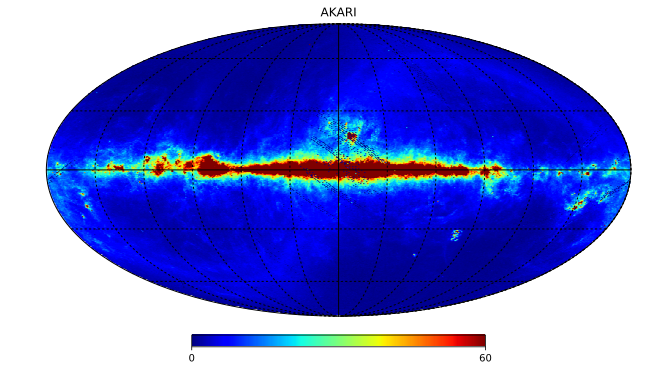

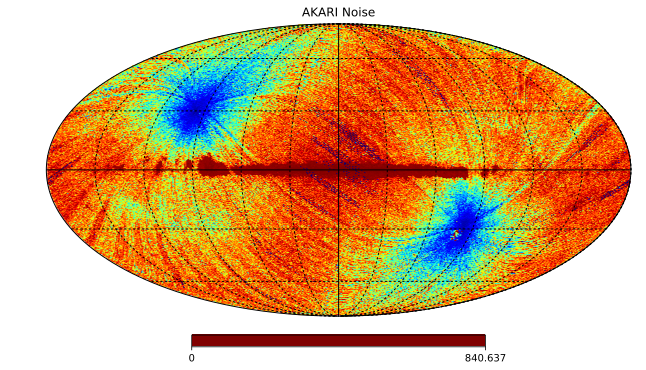

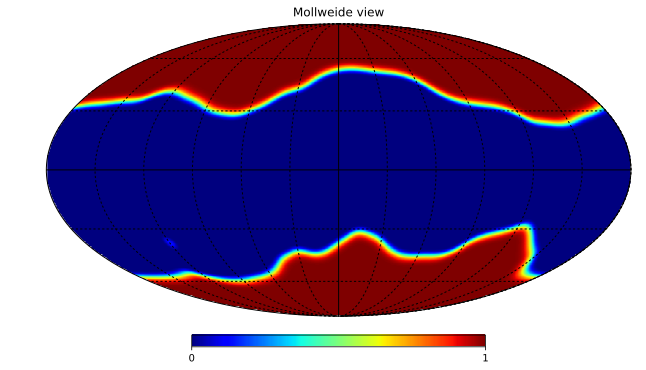

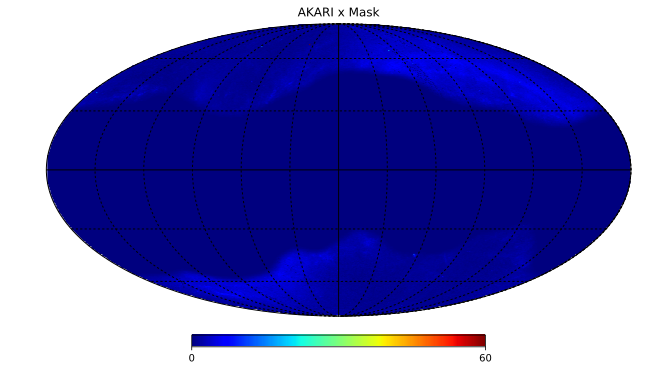

In [75]:
hp.mollview(akari, min=0, max=60, title='AKARI')
hp.graticule()
hp.mollview(akari_noise, title='AKARI Noise', norm='hist')
hp.graticule()
hp.mollview(mask)
hp.graticule()
hp.mollview(mask*akari, min=0, max=60,title='AKARI x Mask')
hp.graticule()

In [32]:
def GetClTot(pixmap, beam=0.,mask=None, lmax=None):
    """
    Extract power spectrum from map and deconvolve for Masking, Pixel Window, Beam
    """
    nside = hp.npix2nside(pixmap.size)
    if mask is None:
        mask = np.ones_like(pixmap)
        fsky = 1.
    else:
        assert hp.isnpixok(mask.size)
        fsky = np.mean(mask**2)
    
    cl = hp.anafast(pixmap*mask, lmax=lmax)
    
    if lmax is None:
        lmax = cl.size - 1 
    
    cl /= hp.pixwin(nside)[:lmax+1]**2 # Pixel window funct
    cl /= hp.gauss_beam(np.deg2rad(beam/60.), lmax=lmax)**2 # Beam
    cl /= fsky # Masking effect
    
    return cl
    

In [33]:
def filter_highpass_lowpass_1d(reclen, lmin, dl):
    # central_freq = samp_freq/float(reclen)
    l = np.arange(reclen)#/2+1) * central_freq
    filt = np.ones(reclen)
    filt[l<lmin-dl/2] = 0.0

    window_for_transition_to_zero = (lmin-dl/2 <= l) * (l <= lmin+dl/2)
    ind=np.where(window_for_transition_to_zero==True)[0]
    reclen_transition_window = len(filt[window_for_transition_to_zero])
    filt[window_for_transition_to_zero] = (1. - np.cos( np.pi* np.arange(reclen_transition_window) /(reclen_transition_window-1))) /2.0

    return filt
        
def GetFl(pixmap, fwhm, mask=None, lmax=None, lmin=300, dl=100):
    if lmax is None:
        lmax = 3.*hp.npix2nside(pixmap.size) - 1.
    fwhm_rad = np.deg2rad(fwhm/60.)
    sigma = fwhm_rad/np.sqrt(8.*np.log(2))
    Bl = hp.gauss_beam(fwhm_rad, lmax=lmax)
    Bl_tilde = 2.*np.pi*sigma**2*Bl
    Cl_tot = GetClTot(pixmap, beam=fwhm, mask=mask, lmax=lmax)
    ell = np.arange(lmax+1)
    return filter_highpass_lowpass_1d(ell.size, lmin=lmin, dl=dl)  * Bl_tilde / (Cl_tot * np.sum((2.*ell+1)*Bl_tilde**2/(4.*np.pi*Cl_tot)))

In [34]:
def FilterMap(pixmap, fwhm, mask=None, lmax=None):
    if mask is None:
        mask = np.ones_like(pixmap)
    else:
        assert hp.isnpixok(mask.size)
    Fl = GetFl(pixmap, fwhm, mask=mask, lmax=lmax)
    alm = hp.map2alm(pixmap*mask, lmax=lmax)
    return hp.alm2map(hp.almxfl(alm, Fl), hp.npix2nside(pixmap.size), lmax=lmax), Fl

In [49]:
akari_filt, fl = FilterMap(akari, 1.5, mask=mask, lmax=12000)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [52]:
fwhm = np.deg2rad(1.5/60.)
sigma = fwhm/np.sqrt(8.*np.log(2))
Bl = hp.gauss_beam(fwhm, lmax=12000)
Bl_tilde = 2.*np.pi*sigma**2*Bl
ell = np.arange(12000+1)
np.sum((2.*ell+1)*Bl_tilde**2/(4.*np.pi*Cl_tot))

0.057347235452919067

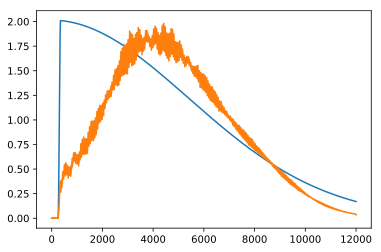

In [55]:
plt.plot(1./np.sum((2.*ell+1)*Bl_tilde**2/(4.*np.pi)) * Bl_tilde * filter_highpass_lowpass_1d(12001, lmin=300, dl=100))
plt.plot(fl)

In [78]:
akari_filt_ = hp.ma(akari_filt)
akari_filt_.mask = np.logical_not(mask)


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


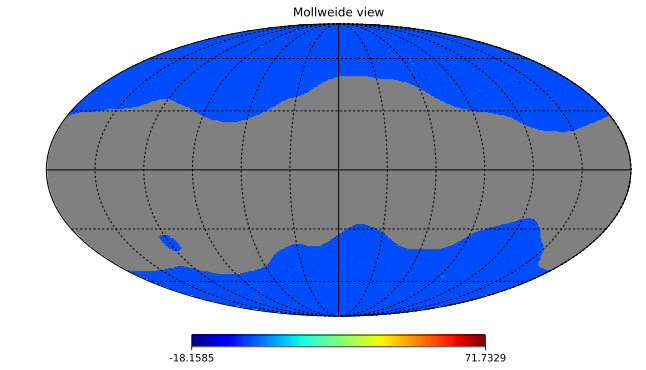

In [79]:
hp.mollview(akari_filt_)
hp.graticule()

In [47]:
Cl_tot = GetClTot(akari, beam=1.5, mask=mask, lmax=12000)


In [48]:
Cl_tot_nomask = GetClTot(akari, beam=1.5,  lmax=12000)


In [18]:
Cl_tot_nomask_nobeam = Cl_tot_nomask.copy()
Cl_tot_nobeam = Cl_tot.copy()

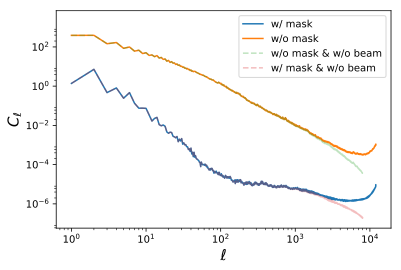

In [60]:
plt.loglog(Cl_tot, label='w/ mask')
plt.loglog(Cl_tot_nomask, label='w/o mask')
plt.loglog(Cl_tot_nomask_nobeam, '--', alpha=0.3, label='w/o mask & w/o beam')
plt.loglog(Cl_tot_nobeam, '--', alpha=0.3, label='w/ mask & w/o beam')
plt.legend()
plt.xlabel(r'$\ell$', size=15)
plt.ylabel(r'$C_{\ell}$', size=15)

(-0.01, 2)

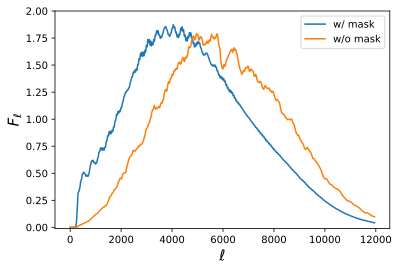

In [85]:
plt.plot(moving_average(1./np.sum((2.*ell+1)*Bl_tilde**2/(4.*np.pi*Cl_tot)) * Bl_tilde * filter_highpass_lowpass_1d(12001, lmin=300, dl=100)/Cl_tot, n=50), label='w/ mask')
plt.plot(moving_average(1./np.sum((2.*ell+1)*Bl_tilde**2/(4.*np.pi*Cl_tot_nomask)) * Bl_tilde * filter_highpass_lowpass_1d(12001, lmin=300, dl=100)/Cl_tot_nomask,n=50), label='w/o mask')
plt.legend()
plt.xlabel(r'$\ell$', size=15)
plt.ylabel(r'$F_{\ell}$', size=15)
plt.ylim([-0.01,2])

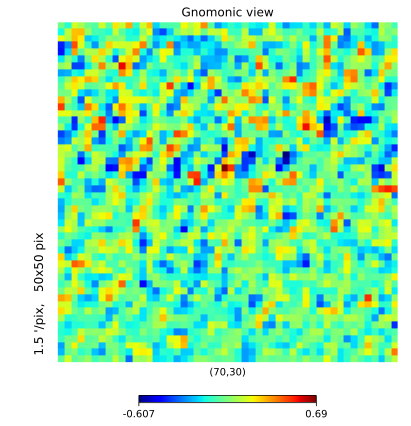

In [86]:
hp.gnomview(akari_filt*mask, rot=[70,30], xsize=50, cmap='jet')
plt.savefig('/Users/fbianchini/Desktop/b.pdf', bboxes_inches='tight')

In [80]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

